<a href="https://colab.research.google.com/github/mdssumin/SmartFactory_with_MDSTech_2nd/blob/main/Personal_Project%20/Sumin_Lee/mask_kaggle_yolov5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/code/rohitgadhwar/face-mask-detection-yolov5/notebook

In [1]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jetsoneddy","key":"8646baabc3c28a96e0a9dd0154106805"}'}

In [2]:
ls -1ha kaggle.json

kaggle.json


In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning이 발생하지 않도록 해줍니다.
!chmod 600 ~/.kaggle/kaggle.json
# 내가 참가한 대회 리스트 확인
!kaggle competitions list

ref                                                                                           deadline             category            reward  teamCount  userHasEntered  
--------------------------------------------------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
https://www.kaggle.com/competitions/asl-fingerspelling                                        2023-08-24 23:59:00  Research          $200,000        826           False  
https://www.kaggle.com/competitions/icr-identify-age-related-conditions                       2023-08-10 23:59:00  Featured           $60,000       5950           False  
https://www.kaggle.com/competitions/commonlit-evaluate-student-summaries                      2023-10-11 23:59:00  Featured           $60,000        309           False  
https://www.kaggle.com/competitions/bengaliai-speech                                          2023-10-17 23:59:00  Research           $53,000    

In [5]:
!kaggle datasets download -d andrewmvd/face-mask-detection

100% 397M/398M [00:19<00:00, 23.2MB/s]
100% 398M/398M [00:19<00:00, 21.7MB/s]


In [8]:
%cd /content
!mkdir dataset_mask_detection
%cd dataset_mask_detection
!unzip ../face-mask-detection.zip

/content
/content/dataset_mask_detection
Archive:  ../face-mask-detection.zip
  inflating: annotations/maksssksksss0.xml  
  inflating: annotations/maksssksksss1.xml  
  inflating: annotations/maksssksksss10.xml  
  inflating: annotations/maksssksksss100.xml  
  inflating: annotations/maksssksksss101.xml  
  inflating: annotations/maksssksksss102.xml  
  inflating: annotations/maksssksksss103.xml  
  inflating: annotations/maksssksksss104.xml  
  inflating: annotations/maksssksksss105.xml  
  inflating: annotations/maksssksksss106.xml  
  inflating: annotations/maksssksksss107.xml  
  inflating: annotations/maksssksksss108.xml  
  inflating: annotations/maksssksksss109.xml  
  inflating: annotations/maksssksksss11.xml  
  inflating: annotations/maksssksksss110.xml  
  inflating: annotations/maksssksksss111.xml  
  inflating: annotations/maksssksksss112.xml  
  inflating: annotations/maksssksksss113.xml  
  inflating: annotations/maksssksksss114.xml  
  inflating: annotations/maksssksks

dataset_mask_detection폴더 만들어서 annotations 폴더와 images 폴더를 해당 폴더 로 이동

In [21]:
%cd /content/
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -qr requirements.txt

/content
fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/yolov5


In [11]:
# Import required libraries
import pandas as pd
import numpy as np
import os
import glob
from datetime import datetime
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [12]:
input_data = '/content/dataset_mask_detection/'
output_data = '/content/yolov5/data'

In [13]:
annotations_path = "/content/dataset_mask_detection/annotations"
images_path = "/content/dataset_mask_detection/images"

In [14]:
dataset = {
            "file":[],
            "name":[],
            "width":[],
            "height":[],
            "xmin":[],
            "ymin":[],
            "xmax":[],
            "ymax":[],
           }

for anno in glob.glob(annotations_path+"/*.xml"):
    tree = ET.parse(anno)

    for elem in tree.iter():
        if 'size' in elem.tag:
            for attr in list(elem):
                if 'width' in attr.tag:
                    width = int(round(float(attr.text)))
                if 'height' in attr.tag:
                    height = int(round(float(attr.text)))

        if 'object' in elem.tag:
            for attr in list(elem):

                if 'name' in attr.tag:
                    name = attr.text
                    dataset['name']+=[name]
                    dataset['width']+=[width]
                    dataset['height']+=[height]
                    dataset['file']+=[anno.split('/')[-1][0:-4]]

                if 'bndbox' in attr.tag:
                    for dim in list(attr):
                        if 'xmin' in dim.tag:
                            xmin = int(round(float(dim.text)))
                            dataset['xmin']+=[xmin]
                        if 'ymin' in dim.tag:
                            ymin = int(round(float(dim.text)))
                            dataset['ymin']+=[ymin]
                        if 'xmax' in dim.tag:
                            xmax = int(round(float(dim.text)))
                            dataset['xmax']+=[xmax]
                        if 'ymax' in dim.tag:
                            ymax = int(round(float(dim.text)))
                            dataset['ymax']+=[ymax]

In [15]:
df=pd.DataFrame(dataset)
df.head()

,file,name,width,height,xmin,ymin,xmax,ymax
0,maksssksksss807,with_mask,400,267,19,47,35,61
1,maksssksksss807,with_mask,400,267,58,42,73,57
2,maksssksksss807,with_mask,400,267,85,63,93,71
3,maksssksksss807,with_mask,400,267,108,56,125,69
4,maksssksksss807,with_mask,400,267,165,28,184,49


In [16]:
name_dict = {
    'with_mask': 0,
    'mask_weared_incorrect': 1,
    'without_mask': 2
}

df['class'] = df['name'].map(name_dict)

In [17]:
np.sort(df.name.unique())

array(['mask_weared_incorrect', 'with_mask', 'without_mask'], dtype=object)

In [18]:
fileNames = [*os.listdir("/content/dataset_mask_detection/images")]
print('There are {} images in the dataset'.format(len(fileNames)))

There are 853 images in the dataset


In [19]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(fileNames, test_size=0.1, random_state=22)
test, val = train_test_split(test, test_size=0.7, random_state=22)
print("Length of Train =",len(train))
print("="*30)
print("Length of Valid =",len(val))
print("="*30)
print("Length of test =", len(test))

Length of Train = 767
Length of Valid = 61
Length of test = 25


In [23]:
# create separate train test and validation dir inside yolo/data/
# os.chdir('/content/kaggle_workspace/')
os.mkdir('/content/yolov5/data/train')
os.mkdir('/content/yolov5/data/val')
os.mkdir('/content/yolov5/data/test')
os.mkdir('/content/yolov5/data/train/images')
os.mkdir('/content/yolov5/data/train/labels')
os.mkdir('/content/yolov5/data/test/images')
os.mkdir('/content/yolov5/data/test/labels')
os.mkdir('/content/yolov5/data/val/images')
os.mkdir('/content/yolov5/data/val/labels')

In [24]:
from PIL import Image

def copyImages(imageList, folder_Name):
    for image in imageList:
        img = Image.open(input_data+"/images/"+image)
        img1 = img.resize((640, 480))
        _ = img1.save("/content/yolov5/data/"+folder_Name+"/images/"+image)

copyImages(train, "train")
copyImages(val, "val")
copyImages(test, "test")

In [25]:
df.head()

,file,name,width,height,xmin,ymin,xmax,ymax,class
0,maksssksksss807,with_mask,400,267,19,47,35,61,0
1,maksssksksss807,with_mask,400,267,58,42,73,57,0
2,maksssksksss807,with_mask,400,267,85,63,93,71,0
3,maksssksksss807,with_mask,400,267,108,56,125,69,0
4,maksssksksss807,with_mask,400,267,165,28,184,49,0


In [26]:
df['xmax'] = (640/df['width'])*df['xmax']
df['ymax'] = (480/df['height'])*df['ymax']
df['xmin'] = (640/df['width'])*df['xmin']
df['ymin'] = (480/df['height'])*df['ymin']

In [27]:
df[['xmax', 'ymax', 'xmin', 'ymin']] = df[['xmax', 'ymax', 'xmin', 'ymin']].astype('int64')

In [28]:
df['x_center'] = (df['xmax']+df['xmin'])/(2*640)
df['y_center'] = (df['ymax']+df['ymin'])/(2*480)
df['box_height'] = (df['xmax']-df['xmin'])/(640)
df['box_width'] = (df['ymax']-df['ymin'])/(480)

In [29]:
df.head()

,file,name,width,height,xmin,ymin,xmax,ymax,class,x_center,y_center,box_height,box_width
0,maksssksksss807,with_mask,400,267,30,84,56,109,0,0.067187,0.201042,0.040625,0.052083
1,maksssksksss807,with_mask,400,267,92,75,116,102,0,0.162500,0.184375,0.037500,0.056250
2,maksssksksss807,with_mask,400,267,136,113,148,127,0,0.221875,0.250000,0.018750,0.029167
3,maksssksksss807,with_mask,400,267,172,100,200,124,0,0.290625,0.233333,0.043750,0.050000
4,maksssksksss807,with_mask,400,267,264,50,294,88,0,0.435937,0.143750,0.046875,0.079167


In [30]:
df = df.astype('string')

In [31]:
def create_labels(image_list, data_name):
    fileNames = [x.split(".")[0] for x in image_list]

    for name in fileNames:
        data = df[df.file==name]
        box_list = []

        for index in range(len(data)):
            row = data.iloc[index]
            box_list.append(row['class']+" "+row["x_center"]+" "+row["y_center"]\
                        +" "+row["box_height"]+" "+row["box_width"])

        text = "\n".join(box_list)
        with open("/content/yolov5/data/"+data_name+"/labels/"+name+".txt", "w") as file:
            file.write(text)


create_labels(train, "train")
create_labels(val, "val")
create_labels(test, "test")

In [32]:
 # go to YOLO directory
%cd /content/yolov5

/content/yolov5


In [45]:
# to display images
from IPython.display import Image, clear_output
import torch
from yolov5 import utils
display = utils.notebook_init()

YOLOv5 🚀 v7.0-196-gacdf73b Python-3.10.6 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (4 CPUs, 25.5 GB RAM, 26.1/166.8 GB disk)


In [35]:
# configure .yaml file to guide the model for training
yaml_text = """train: data/train/images
val: data/train/images

nc: 3
names: ['with_mask', 'mask_weared_incorrect', 'without_mask']"""

with open("data/data.yaml", 'w') as file:
    file.write(yaml_text)

%cat data/data.yaml

train: data/train/images
val: data/train/images

nc: 3
names: ['with_mask', 'mask_weared_incorrect', 'without_mask']

In [36]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [37]:
%%writetemplate models/custom_yolov5s.yaml

# parameters
nc: 3  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
    - [10,13, 16,30, 33,23]  # P3/8
    - [30,61, 62,45, 59,119]  # P4/16
    - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
    [[-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, 'nearest']],
    [[-1, 6], 1, Concat, [1]],  # cat backbone P4
    [-1, 3, BottleneckCSP, [512, False]],  # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, 'nearest']],
    [[-1, 4], 1, Concat, [1]],  # cat backbone P3
    [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

    [-1, 1, Conv, [256, 3, 2]],
    [[-1, 14], 1, Concat, [1]],  # cat head P4
    [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

    [-1, 1, Conv, [512, 3, 2]],
    [[-1, 10], 1, Concat, [1]],  # cat head P5
    [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

    [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
    ]

In [38]:
# train yolov5s on custom data for 100 epochs
# time its performance
# we are going to using pre-trained weights from yolov5.pt model

start = datetime.now()
!python train.py --img 640 --batch 32 --epochs 50 --data data/data.yaml --cfg models/custom_yolov5s.yaml --weights yolov5s.pt --name yolov5s_results  --cache
end = datetime.now()

WARNING ⚠️ 'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING ⚠️ 'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")

train: weights=yolov5s.pt, cfg=models/custom_yolov5s.yaml, data=data/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label

In [39]:
print("Runtime =",end-start)

Runtime = 0:14:09.971152


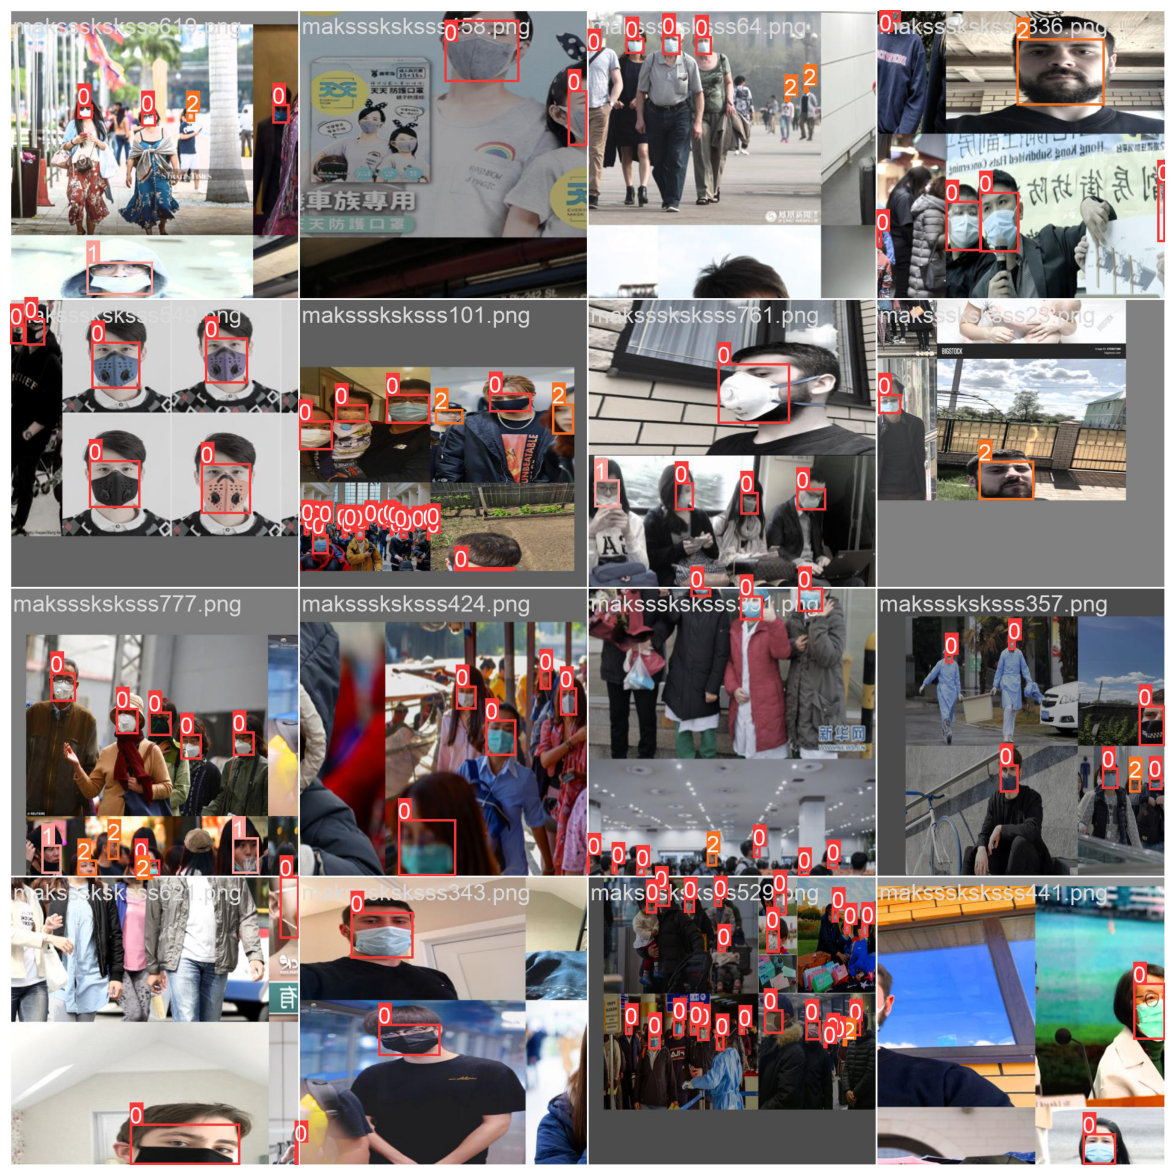

In [40]:
# lets visualize the training results
img = plt.imread('runs/train/yolov5s_results/train_batch0.jpg')
plt.figure(figsize=(20,15))
plt.imshow(img)
plt.axis('off')
plt.show()

In [42]:
# 이미지

from IPython.display import Image
import os

!python detect.py --weights /content/yolov5/runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.7 --source /content/dataset_mask_detection/images/maksssksksss15.png


WARNING ⚠️ 'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING ⚠️ 'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")

detect: weights=['/content/yolov5/runs/train/yolov5s_results/weights/best.pt'], source=/content/dataset_mask_detection/images/maksssksksss15.png, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.7, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hid

In [43]:
# 영상 추론

from IPython.display import YouTubeVideo, display
import os

!python detect.py --weights /content/yolov5/runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.7 --source /content/mask_test_video.mp4


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
video 1/1 (3282/8279) /content/mask_test_video.mp4: 256x416 5 with_masks, 6.6ms
video 1/1 (3283/8279) /content/mask_test_video.mp4: 256x416 4 with_masks, 6.9ms
video 1/1 (3284/8279) /content/mask_test_video.mp4: 256x416 5 with_masks, 6.6ms
video 1/1 (3285/8279) /content/mask_test_video.mp4: 256x416 5 with_masks, 6.1ms
video 1/1 (3286/8279) /content/mask_test_video.mp4: 256x416 6 with_masks, 6.5ms
video 1/1 (3287/8279) /content/mask_test_video.mp4: 256x416 6 with_masks, 6.0ms
video 1/1 (3288/8279) /content/mask_test_video.mp4: 256x416 5 with_masks, 6.6ms
video 1/1 (3289/8279) /content/mask_test_video.mp4: 256x416 5 with_masks, 1 without_mask, 6.1ms
video 1/1 (3290/8279) /content/mask_test_video.mp4: 256x416 5 with_masks, 1 without_mask, 6.8ms
video 1/1 (3291/8279) /content/mask_test_video.mp4: 256x416 5 with_masks, 1 without_mask, 8.2ms
video 1/1 (3292/8279) /content/mask_test_video.mp4: 256x416 5 with_masks, 1 without_mask, 6.4ms
video 1/1 (3293/8279

In [44]:
from google.colab import files
files.download('/content/yolov5/runs/detect/exp3/mask_test_video.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>